# 训练

In [1]:
# setsid python cfg/train_yolov8.py > logs/train_yolov8.log 2>&1 &

# 变量定义

In [1]:
# 参数
model_name = 'yolov8n'
model_stru = '-p2'  # -p2
model_cfg = '_train_val'  # _train_val _train_val_aug
exp_name = f'{model_name}{model_stru}{model_cfg}'
USE_VAL = 'val' in model_cfg

# 路径
best_model_path = f'runs/ultralytics/{exp_name}/train/weights/best.pt'
train_log_path = f'runs/ultralytics/{exp_name}/train/results.csv'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='yolov8n-p2_train_val'
best_model_path='runs/ultralytics/yolov8n-p2_train_val/train/weights/best.pt'
train_log_path='runs/ultralytics/yolov8n-p2_train_val/train/results.csv'


# 日志分析-验证

['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


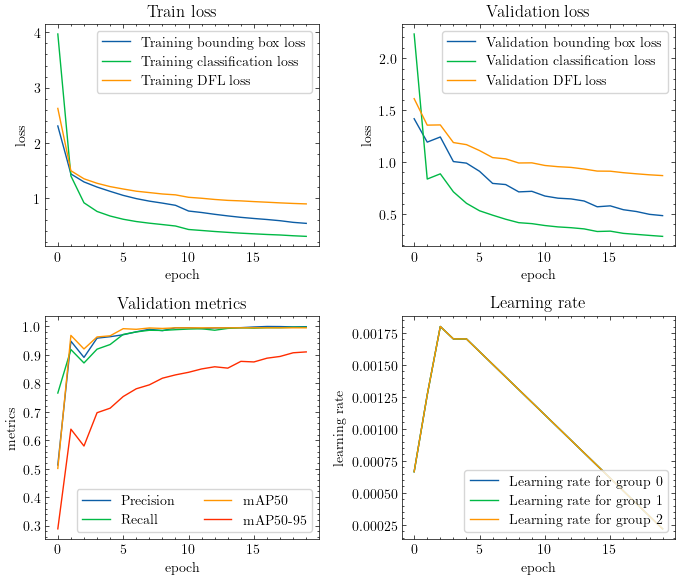

In [2]:
import matplotlib.pyplot as plt
import scienceplots
from src.utils.read import read_ultrlytics_train_log_csv

plt.style.use('science')

re = read_ultrlytics_train_log_csv(train_log_path)

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False, dpi=100)
axes = axes.flatten()

# 第一个子图
axes[0].plot(re.index, re['train/box_loss'],
             label='Training bounding box loss')
axes[0].plot(re.index, re['train/cls_loss'],
             label='Training classification loss')
axes[0].plot(re.index, re['train/dfl_loss'], label='Training DFL loss')
axes[0].legend(loc='upper right', frameon=True)

# 第二个子图
axes[1].plot(re.index, re['val/box_loss'],
             label='Validation bounding box loss')
axes[1].plot(re.index, re['val/cls_loss'],
             label='Validation classification loss')
axes[1].plot(re.index, re['val/dfl_loss'], label='Validation DFL loss')
axes[1].legend(loc='upper right', frameon=True)

# 第三个子图
axes[2].plot(re.index, re['metrics/precision(B)'],
             label='Precision')
axes[2].plot(re.index, re['metrics/recall(B)'], label='Recall')
axes[2].plot(re.index, re['metrics/mAP50(B)'], label='mAP50')
axes[2].plot(re.index, re['metrics/mAP50-95(B)'], label='mAP50-95')
axes[2].legend(loc='lower right', ncol=2, frameon=True)

# 第四个子图
axes[3].plot(re.index, re['lr/pg0'], label='Learning rate for group 0')
axes[3].plot(re.index, re['lr/pg1'], label='Learning rate for group 1')
axes[3].plot(re.index, re['lr/pg2'], label='Learning rate for group 2')
axes[3].legend(loc='lower right', frameon=True)

# 参数配置
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')

axes[0].set_ylabel('loss')
axes[1].set_ylabel('loss')
axes[2].set_ylabel('metrics')
axes[3].set_ylabel('learning rate')

axes[0].set_title('Train loss')
axes[1].set_title('Validation loss')
axes[2].set_title('Validation metrics')
axes[3].set_title('Learning rate')

plt.tight_layout()
plt.savefig(f'results/figs/train/train_log_{exp_name}.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [7]:
# 参数设置
nms_conf = 0.001
nms_iou = 0.6

# 测试

In [3]:
from ultralytics import YOLO
import torch

# 加载模型
model = YOLO(best_model_path)

# 保存结果
test_metrics = {}

# 在各测试集进行测试
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在测试: {data_type}')
    if not USE_VAL:
        data_yaml = f'datasets/cfg/lard_{data_type}.yaml'
    else:
        data_yaml = f'datasets/cfg/lard_val_{data_type}.yaml'

    print(data_yaml)

    metrics = model.val(
        data=data_yaml,
        imgsz=640,
        batch=64,
        save_json=True,  # 保存预测结果JSON
        conf=nms_conf,  # 检测的目标置信度阈值
        iou=nms_iou,  # NMS使用的IOU阈值
        device=0,
        split='test',  # val时使用的数据集划分
        project='runs/ultralytics',
        name=f'{exp_name}/val_{data_type}'
    )

    # test_metrics[data_type] = metrics

torch.cuda.empty_cache()


Ultralytics YOLOv8.0.203 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_synth
datasets/cfg/lard_val_test_synth.yaml


YOLOv8n-p2 summary (fused): 207 layers, 2921172 parameters, 0 gradients, 12.2 GFLOPs
val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_synth/labels.cache... 2212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2212/2212 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:43<00:00,  1.23s/it]
                   all       2212       2212      0.973      0.965      0.987      0.769
Speed: 0.4ms preprocess, 6.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving runs/ultralytics/yolov8n-p2_train_val/val_test_synth2/predictions.json...
Results saved to runs/ultralytics/yolov8n-p2_train_val/val_test_synth2
Ultralytics YOLOv8.0.203 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_real_nominal
datasets/cfg/lard_val_test_real_nominal.yaml


val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_real_nominal/labels.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:04<00:00,  2.68s/it]
                   all       1500       1500       0.88      0.772      0.852      0.604
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Saving runs/ultralytics/yolov8n-p2_train_val/val_test_real_nominal2/predictions.json...
Results saved to runs/ultralytics/yolov8n-p2_train_val/val_test_real_nominal2
Ultralytics YOLOv8.0.203 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_real_edge
datasets/cfg/lard_val_test_real_edge.yaml


val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_real_edge/labels.cache... 311 images, 0 backgrounds, 0 corrupt: 100%|██████████| 311/311 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.61s/it]
                   all        311        311       0.72      0.473        0.6      0.375
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving runs/ultralytics/yolov8n-p2_train_val/val_test_real_edge2/predictions.json...
Results saved to runs/ultralytics/yolov8n-p2_train_val/val_test_real_edge2


# 评估

In [2]:
import json
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics
from src.utils.metric import get_coco_imgname_2_imgid


# 保存评价结果对象
coco_evals = {}

# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/ultralytics/{exp_name}/val_{data_type}/predictions.json'
    prediction_modified_file = f'runs/ultralytics/{exp_name}/val_{data_type}/predictions_modified.json'

    name_2_id = get_coco_imgname_2_imgid(annotation_file)
    
    # 原始预测结果文件
    with open(prediction_file, 'r') as f:
        pred = json.load(f)

    for item in pred:
        item['image_id'] = name_2_id[item['image_id']]

    # 修改后的预测结果
    with open(prediction_modified_file, 'w') as f:
        json.dump(pred, f)

    # 指标计算
    cocoEval = cal_coco_metrics(annotation_file, prediction_modified_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


正在评价: test_synth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.50s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.721
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.833
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.721,0.541,0.312
"AP (IoU=0.50, area=all, maxDets=100)",0.976,0.805,0.519
"AP (IoU=0.75, area=all, maxDets=100)",0.833,0.584,0.319
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.162,0.103
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.414,0.220
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.773,0.744,0.409
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.757,0.572,0.342
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.762,0.586,0.364
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.762,0.586,0.364
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.201,0.123


test_synth


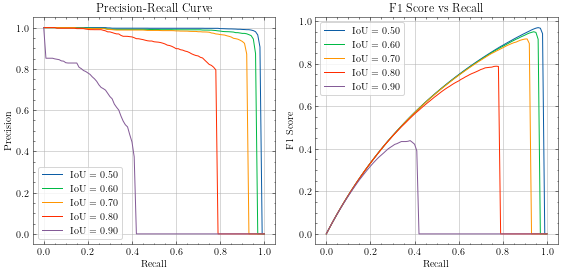

test_real_nominal


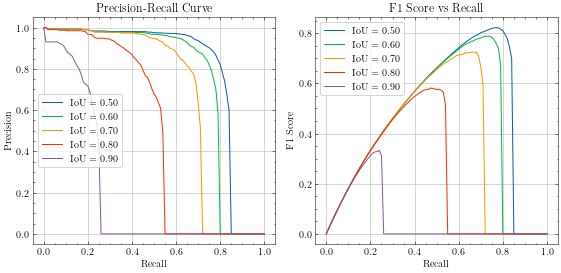

test_real_edge


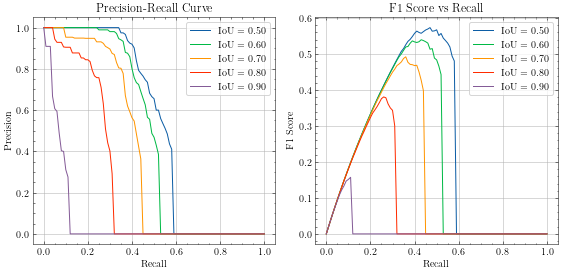

In [3]:
from src.utils.plot import plot_pr_curve

plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 测速

In [33]:
import torch
from ultralytics import YOLO
import glob
from tqdm import tqdm


# 加载模型
model = YOLO(best_model_path)

# 保存结果
all_speed = {}

# 设备预热
num_pre = 500
path = f'datasets/lard/YoloFormat/test_synth/images/'
image_paths = glob.glob(f"{path}*")
for image_path in tqdm(image_paths[:num_pre], ncols=100, desc="预热"):
    _ = model.predict(
        source=image_path,
        imgsz=640,
        conf=nms_conf,
        iou=nms_iou,
        device=0,
        verbose=False
    )
print("预热完成")

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    path = f'datasets/lard/YoloFormat/{data_type}/images/'
    image_paths = glob.glob(f"{path}*")
    infer_time = []

    for image_path in tqdm(image_paths, ncols=100, desc="推理"):
        re = model.predict(
            source=image_path,
            imgsz=640,
            conf=nms_conf,
            iou=nms_iou,
            device=0,
            verbose=False
        )
        # 累加当前推理时间：前处理, 前向传播, 后处理
        infer_time.append(sum(list(re[0].speed.values())))

    average_time = sum(infer_time)/len(infer_time)  # 平均时间
    fps = 1000/average_time  # 帧率

    # 存储结果
    all_speed[data_type] = [average_time, fps]

    # 输出信息
    print(f"数据集: {data_type}")
    print(f"平均推理时间: {average_time:.2f} ms")
    print(f"平均FPS: {fps:.2f}")

# 显存清理
torch.cuda.empty_cache()
print('测速结束')


推理:   0%|                                                                | 0/2212 [00:00<?, ?it/s]

推理: 100%|█████████████████████████████████████████████████████| 2212/2212 [01:52<00:00, 19.62it/s]

数据集: test_synth
平均推理时间: 9.95 ms
平均FPS: 100.53
测速结束


In [8]:
# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(
    f'results/tables/metrics/metrics_{exp_name}.csv',
    float_format='%.3f')
display(results.round(3))

,test_synth,test_real_nominal,test_real_edge
metrics,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.724,0.542,0.313
"AP (IoU=0.50, area=all, maxDets=100)",0.976,0.804,0.522
"AP (IoU=0.75, area=all, maxDets=100)",0.840,0.585,0.321
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.162,0.103
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.414,0.220
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.776,0.745,0.410
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.757,0.572,0.342
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.764,0.587,0.368
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.764,0.587,0.368


# 推理-持久化

In [9]:
# from ultralytics import YOLO
# import torch

# # 加载模型
# model = YOLO(best_model_path)

# # 在各测试集进行推理
# for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

#     print(f'正在推理: {data_type}')
#     data_file = f'datasets/lard/YoloFormat/{data_type}/images/'

#     results = model.predict(
#         source=data_file,
#         stream=True,  # 流式推理节省内存
#         save=True,  # 保存带检测结果的图像
#         imgsz=640,
#         conf=nms_conf,
#         iou=nms_iou,
#         device=0,
#         name=f'{model_name}/pred_{data_type}'
#     )

#     # 遍历迭代器
#     for r in results:
#         pass

# # 清空显存占用
# torch.cuda.empty_cache()